In [1]:
%matplotlib inline

from matplotlib import pyplot as plt
from scipy.stats import describe
import h5py
import numpy as np

## NYU Depth V2 Dataset

The [NYU-Depth V2](https://cs.nyu.edu/~silberman/datasets/nyu_depth_v2.html) data set is comprised of video sequences from a variety of indoor scenes as recorded by both the RGB and Depth cameras from the Microsoft Kinect. It features:

- 1449 densely labeled pairs of aligned RGB and depth images
- 464 new scenes taken from 3 cities
- 407,024 new unlabeled frames

Each object is labeled with a class and an instance number (cup1, cup2, cup3, etc)
The dataset has several components:

- Labeled: A subset of the video data accompanied by dense multi-class labels. This data has also been preprocessed to fill in missing depth labels.
- Raw: The raw rgb, depth and accelerometer data as provided by the Kinect.
- Toolbox: Useful functions for manipulating the data and labels.

In this analysis, we will work with **labeled dataset** which is a subset of the Raw Dataset. It is comprised of pairs of RGB and Depth frames that have been synchronized and annotated with dense labels for every image. In addition to the projected depth maps, the dataset also includes a set of preprocessed depth maps whose missing values have been filled in using the [colorization scheme of Levin et al](http://www.cs.huji.ac.il/~yweiss/Colorization/).
Some of data that is of interest to over research are the following:

- **depths** – HxWxN matrix of in-painted depth maps where H and W are the height and width, respectively and N is the number of images. The values of the depth elements are in meters.
- **images** – HxWx3xN matrix of RGB images where H and W are the height and width, respectively, and N is the number of images.
- **rawDepths** – HxWxN matrix of raw depth maps where H and W are the height and width, respectively, and N is the number of images. These depth maps capture the depth images after they have been projected onto the RGB image plane but before the missing depth values have been filled in. Additionally, the depth non-linearity from the Kinect device has been removed and the values of each depth image are in meters.

## Preparing the data for training

In [2]:
# load the matlab data file with h5py 
# as this particular version is not supported by scipy.io.loadmat
dataset_path = 'nyu_depth_v2_labeled.mat'
NYU_Depth_v2 = h5py.File(dataset_path, 'r')

print('NYU_Depth_v2[\'images\'].shape', NYU_Depth_v2['images'].shape)
print('NYU_Depth_v2[\'depths\'].shape', NYU_Depth_v2['depths'].shape)
print('NYU_Depth_v2[\'rawDepths\'].shape', NYU_Depth_v2['rawDepths'].shape)

NYU_Depth_v2['images'].shape (1449, 3, 640, 480)
NYU_Depth_v2['depths'].shape (1449, 640, 480)
NYU_Depth_v2['rawDepths'].shape (1449, 640, 480)


As can be seen from the previous step, the dataset contains 1499 images.

The **image** is storing the image in a channel first manner which requires some manipulation when using pyplot to show the image.

The **depth** and **raw_depth** are rather trivial to understand.

In [3]:
NYU_v2_images = NYU_Depth_v2['images'][()].astype(np.float32)
NYU_v2_images = np.rollaxis(NYU_v2_images.transpose(), 3)
NYU_v2_images = NYU_v2_images/255
NYU_v2_images.shape

(1449, 480, 640, 3)

In [4]:
NYU_v2_images.nbytes/(1024**2)

5094.140625

In [5]:
NYU_v2_depths = NYU_Depth_v2['depths'][()].astype(np.float32)
NYU_v2_depths = np.rollaxis(NYU_v2_depths, 2, 1)
NYU_v2_depths.shape

(1449, 480, 640)

In [21]:
sub_img = NYU_v2_images[:40]
sub_img.shape

(40, 480, 640, 3)

In [22]:
import cv2
WIDTH = 257
LENGTH = 353
N_CLASSES = 68
MAX_DEPTH = 80

In [23]:
sub_img_resize = np.stack([cv2.resize(img, dsize=(LENGTH, WIDTH)) for img in sub_img])

In [24]:
sub_img_resize.shape

(40, 257, 353, 3)

In [25]:
sub_depth = NYU_v2_depths[:40]
sub_depth.shape

(40, 480, 640)

In [26]:
sub_depth_resize = np.stack([cv2.resize(depth, dsize=(LENGTH, WIDTH)) for depth in sub_depth])
sub_depth_resize.shape

(40, 257, 353)

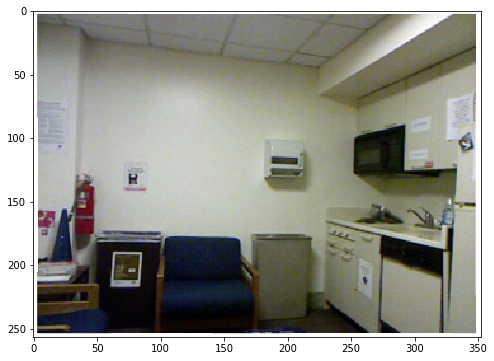

In [27]:
plt.figure(figsize=(20,6))
plt.imshow(sub_img_resize[0])

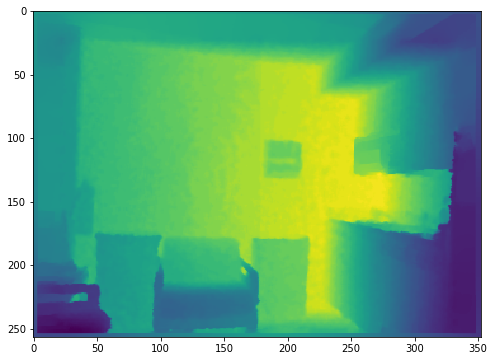

In [28]:
plt.figure(figsize=(20,6))
plt.imshow(sub_depth_resize[0])

In [29]:
#Now we need to convert the depth value into categorical representations
from src.ordinal_utils import ordinal_thresholds_uniform, ordinal_thresholds_exp, ordinal_thresholds_power
from src.ordinal_utils import depth_to_ordinal

In [30]:
exp_thresholds = ordinal_thresholds_exp(MAX_DEPTH, N_CLASSES)

In [31]:
# len(exp_thresholds)
sub_depth_resize_ordinal = depth_to_ordinal(sub_depth_resize.reshape(-1, 257, 353, 1), exp_thresholds)

(40, 257, 353, 68)


In [32]:
sub_depth_resize_ordinal.shape

(40, 257, 353, 68)

In [33]:
# save the preprocessed dataset
np.save("./NYUV2_image.npy", sub_img_resize)
np.save("./NYUV2_depth_ordinal.npy", sub_depth_resize_ordinal)

## Train the model

In [1]:
from src.dorn_keras import DORN_ResNet50_NYUV2
import numpy as np
import tensorflow as tf

Using TensorFlow backend.


In [2]:
X_train = np.load("./NYUV2_image.npy")
y_train = np.load("./NYUV2_depth_ordinal.npy")

In [3]:
X_train.shape

(40, 257, 353, 3)

In [4]:
y_train.shape

(40, 257, 353, 68)

In [5]:
with tf.device('/cpu:0'):
    dorn_model = DORN_ResNet50_NYUV2()
    #dorn_model.summary()
    dorn_model.fit(X_train, y_train, batch_size=4, epochs=10)

Epoch 1/10


InvalidArgumentError: Incompatible shapes: [257] vs. [4]
	 [[{{node training/Adam/gradients/loss/lambda_2_loss/mul_2_grad/BroadcastGradientArgs}} = BroadcastGradientArgs[T=DT_INT32, _class=["loc:@training/Adam/gradients/loss/lambda_2_loss/mul_2_grad/Sum"], _device="/job:localhost/replica:0/task:0/device:CPU:0"](training/Adam/gradients/loss/lambda_2_loss/mul_2_grad/Shape, training/Adam/gradients/loss/lambda_2_loss/mul_2_grad/Shape_1)]]

In [5]:
with tf.device('/gpu:0'):
    dorn_model = DORN_ResNet50_NYUV2()
    #dorn_model.summary()
    dorn_model.fit(X_train, y_train, batch_size=4, epochs=10)